(10000, 100)


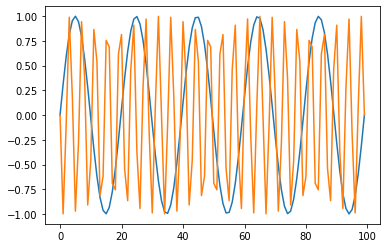

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

def get_sin(length=100, f=10, max_time=50):
    w = 2. * np.pi * f
    t = np.linspace(0, max_time, length)
    return np.sin(w * t)

def gen_signal(length=100):
    return get_sin(length, 10, 50)
    
def get_noise(length=100):
    real_f = 50
    noise_f = np.random.randint(low=-5,high=5)
    f = real_f + noise_f
    return get_sin(length, f,50)

def get_noise_signal(length=100):
    return gen_signal(length) + get_noise(length)
    
def get_noise_batch(batch_size):
    data = []
    for i in range(batch_size):
        data.append(get_noise_signal())
    return np.array(data)

def load_data():
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
#     x_train = x_train.reshape(60000, 784)
    x_train = []
    for i in range(10000):
        x = []
        y = get_sin()
        x_train.append(y)
    return (np.array(x_train))

def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def create_generator():
    generator=Sequential()
    generator.add(Dense(units=32,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=64))
    generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=1024))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=100, activation='tanh'))
    generator.add(Dense(units=100))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=64,input_dim=100))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=32))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=2, activation='softmax'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

def plot_generated_images(X_train, epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
#     noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
#     image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
    noise_signal = get_noise_batch(examples)
    
    generated_images = generator.predict(noise_signal)
#     generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.plot(generated_images[i])
#         plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)


def training(X_train, epochs=1, batch_size=128):
    
    #Loading the data
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=X_train.shape[0])]

    noise_signal = get_noise_batch(X_train.shape[0])
    generated_images = g.predict(noise_signal)
    #Construct different batches of  real and fake data 
    X= np.concatenate([image_batch,noise_signal, generated_images])

    # Labels for generated and real data
    y_dis=np.zeros((3*X_train.shape[0],2))
    y_dis[:,1] = 1
    discriminator.trainable=True
    discriminator.fit(X, y_dis, epochs=3)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
#             noise= np.random.normal(0,1, [batch_size, 100])
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            noise_signal = get_noise_batch(batch_size)
#             print(image_batch[0])
#             print(noise_signal[0])
#             plt.plot(image_batch[0])
#             plt.plot(noise_signal[0])
#             break
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise_signal)
            
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch,noise_signal, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros((3*batch_size,2))
            y_dis[:,1] = 1
            y_dis[:2*batch_size]=[1,0]
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
#             noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones((batch_size,2))
            y_gen[:,1] = 1
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise_signal, y_gen)
            
        if e == 1 or e % 2 == 0:
           
            plot_generated_images(X_train, e, generator, 3)
    return (generator, discriminator)
    
(X_train)=load_data()
print(X_train.shape)

plt.plot(X_train[0])
plt.plot(get_noise())

In [120]:
g=create_generator()
g.summary()

d =create_discriminator()
d.summary()

gan = create_gan(d,g)
gan.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 32)                3232      
_________________________________________________________________
leaky_re_lu_121 (LeakyReLU)  (None, 32)                0         
_________________________________________________________________
dense_182 (Dense)            (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_122 (LeakyReLU)  (None, 64)                0         
_________________________________________________________________
dense_183 (Dense)            (None, 100)               6500      
Total params: 11,844
Trainable params: 11,844
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_62"
_________________________________________________________________
Layer (type)              

Epoch 1/3
30000/30000 [==============================] - 1s 36us/step - loss: 0.0677
Epoch 2/3
30000/30000 [==============================] - 1s 30us/step - loss: 0.0011
Epoch 3/3
30000/30000 [==============================] - 1s 30us/step - loss: 3.2571e-04


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  5%|▍         | 6/128 [00:00<00:02, 51.74it/s]

Epoch 2


  5%|▍         | 6/128 [00:00<00:02, 59.67it/s]

Epoch 3


  5%|▍         | 6/128 [00:00<00:02, 56.25it/s]

Epoch 4


  4%|▍         | 5/128 [00:00<00:02, 49.94it/s]

Epoch 5


  5%|▍         | 6/128 [00:00<00:02, 54.03it/s]

Epoch 6


  5%|▍         | 6/128 [00:00<00:02, 56.15it/s]

Epoch 7


  5%|▌         | 7/128 [00:00<00:01, 64.16it/s]

Epoch 8


  5%|▍         | 6/128 [00:00<00:02, 59.38it/s]

Epoch 9


  5%|▍         | 6/128 [00:00<00:02, 54.64it/s]

Epoch 10


  4%|▍         | 5/128 [00:00<00:02, 43.42it/s]

Epoch 11


  5%|▌         | 7/128 [00:00<00:02, 58.84it/s]

Epoch 12


  5%|▍         | 6/128 [00:00<00:02, 59.05it/s]

Epoch 13


  5%|▌         | 7/128 [00:00<00:01, 61.66it/s]

Epoch 14


  4%|▍         | 5/128 [00:00<00:03, 40.59it/s]

Epoch 15


  5%|▍         | 6/128 [00:00<00:02, 56.23it/s]

Epoch 16


  5%|▍         | 6/128 [00:00<00:02, 56.87it/s]

Epoch 17


  5%|▌         | 7/128 [00:00<00:01, 62.66it/s]

Epoch 18


  5%|▍         | 6/128 [00:00<00:02, 56.80it/s]

Epoch 19


  5%|▌         | 7/128 [00:00<00:01, 63.40it/s]

Epoch 20


  5%|▌         | 7/128 [00:00<00:01, 61.24it/s]

Epoch 21


  5%|▌         | 7/128 [00:00<00:01, 61.79it/s]

Epoch 22


  5%|▌         | 7/128 [00:00<00:01, 60.70it/s]

Epoch 23


  5%|▌         | 7/128 [00:00<00:01, 61.23it/s]

Epoch 24


  5%|▍         | 6/128 [00:00<00:02, 52.34it/s]

Epoch 25


100%|██████████| 128/128 [00:02<00:00, 58.32it/s]


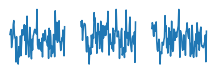

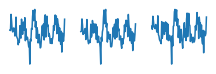

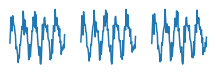

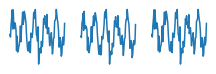

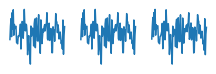

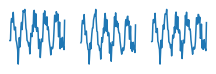

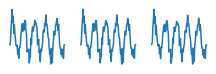

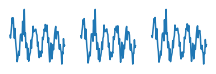

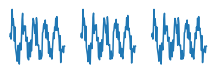

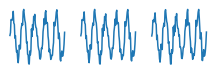

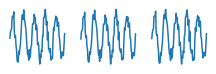

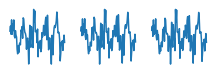

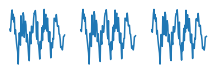

In [176]:
(g,d) = training(X_train, 25, 128)

estimation of the descriminator
noise [[8.4133520e-05 9.9991584e-01]]
real signal [[0.66518044 0.3348195 ]]
noised signal [[0.96616435 0.03383566]]


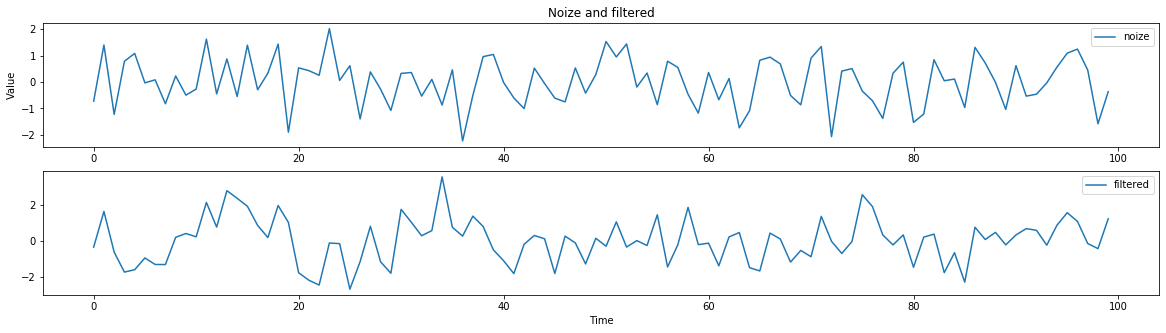

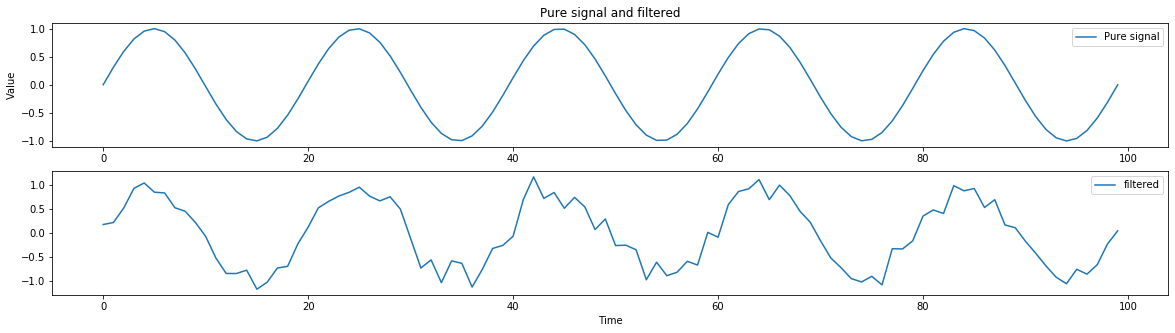

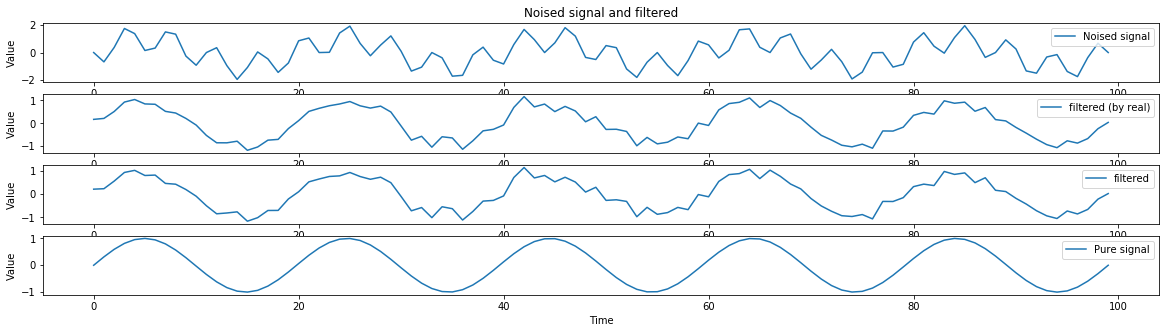

In [179]:
noise= np.random.normal(0,1, [1, 100])
predicted_by_noise = g.predict(noise)[0]
plt.figure(figsize=(20, 5))

plt.subplot(2, 1, 1)
plt.title('Noize and filtered')
plt.ylabel('Value')
plt.plot(noise[0], label='noize')
plt.legend()
plt.ylabel('Value')
plt.subplot(2, 1, 2)
plt.plot(predicted_by_noise, label='filtered')
plt.xlabel('Time')
plt.legend()



plt.figure(figsize=(20, 5))
predicted_by_real_signal = g.predict(np.array([X_train[0]]))[0]

plt.subplot(2, 1, 1)
plt.title('Pure signal and filtered')
plt.ylabel('Value')
plt.plot(X_train[0], label='Pure signal')
plt.legend()
plt.ylabel('Value')
plt.subplot(2, 1, 2)
plt.plot(predicted_by_real_signal, label='filtered')
plt.xlabel('Time')
plt.legend()




noised_signal = get_noise_signal()
plt.figure(figsize=(20, 5))
real_signal = gen_signal()
predicted_by_noised_signal = g.predict(np.array([noised_signal]))[0]
predicted_by_real_signal = g.predict(np.array([real_signal]))[0]

plt.subplot(4, 1, 1)
plt.title('Noised signal and filtered')
plt.ylabel('Value')
plt.plot(noised_signal, label='Noised signal')
plt.legend()

plt.ylabel('Value')
plt.subplot(4, 1, 2)
plt.plot(predicted_by_real_signal, label='filtered (by real)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.ylabel('Value')
plt.subplot(4, 1, 3)
plt.plot(predicted_by_noised_signal, label='filtered')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(4, 1, 4)
plt.ylabel('Value')
plt.plot(real_signal, label='Pure signal')
plt.xlabel('Time')
plt.legend()

print('estimation of the descriminator')
print('noise', d.predict(noise))
print('real signal', d.predict(np.array([real_signal])))
print('noised signal', d.predict(np.array([noised_signal])))

In [178]:
predicted = d.predict(np.array([gen_signal()]))
print(predicted)

noise= np.random.normal(0,1, [1, 100])
predicted = d.predict(noise)
print(predicted)
print(X.shape)

# batch_size = 500
# image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
# noise_signal = get_noise_batch(batch_size)
# generated_images = g.predict(noise_signal)
# #Construct different batches of  real and fake data 
# X= np.concatenate([image_batch,noise_signal, generated_images])

# # Labels for generated and real data
# y_dis=np.zeros((3*batch_size,2))
# y_dis[:,1] = 1
# # d.trainable=False
# # d.fit(X, y_dis, epochs=20)
# d.summary()


[[0.66518044 0.3348195 ]]
[[3.6070338e-09 1.0000000e+00]]
(1500, 100)
